In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt
import json
from glob import glob
from utils import plot_results
from math import ceil
from fisiocomPinn.Net import *
from fisiocomPinn.Trainer import *
from fisiocomPinn.Validator import *
from fisiocomPinn.Loss import *
from fisiocomPinn.Loss_PINN import *
from fisiocomPinn.Utils import *

# Definições iniciais

## Initializing Constants

In [2]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

## Reading results file

In [3]:
def get_infection_site(struct_name):

    center_str = (struct_name).split("__")[-3].split("(")[-1].split(")")[0].split(",")

    center = (float(center_str[0]), float(center_str[1]))

    radius = float(struct_name.split("__")[-2].split("--")[-1].split(".pkl")[0])

    return center, radius


def read_files(path):
    file_list = sorted(glob(path + "/*"))

    speed_up_list = []
    Cl_list = []
    Cp_list = []

    for file in file_list:

        variable = lambda a: a.split("/")[-1].split("__")[0]

        if variable(file) == "Cl":
            Cl_list.append(file)

        elif variable(file) == "Cp":
            Cp_list.append(file)

        elif variable(file) == "speed_up":
            speed_up_list.append(file)

    return Cl_list, Cp_list, speed_up_list


def format_array(Cp_file, Cl_file):

    with open(Cp_file, "rb") as f:
        Cp = pk.load(f)

    with open(Cl_file, "rb") as f:
        Cl = pk.load(f)

    center, radius = get_infection_site(Cp_file)

    return Cp, Cl, center, radius

In [4]:
Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

## Formatting input parameters

In [5]:
def get_mesh_properties(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    verbose=True,
):

    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    if verbose:
        print(
            "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
                size_t,
                size_x,
                size_y,
            )
        )

    return (size_x, size_y, size_t)

In [6]:
size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

Steps in time = 1001
Steps in space_x = 100
Steps in space_y = 1



## Input verification

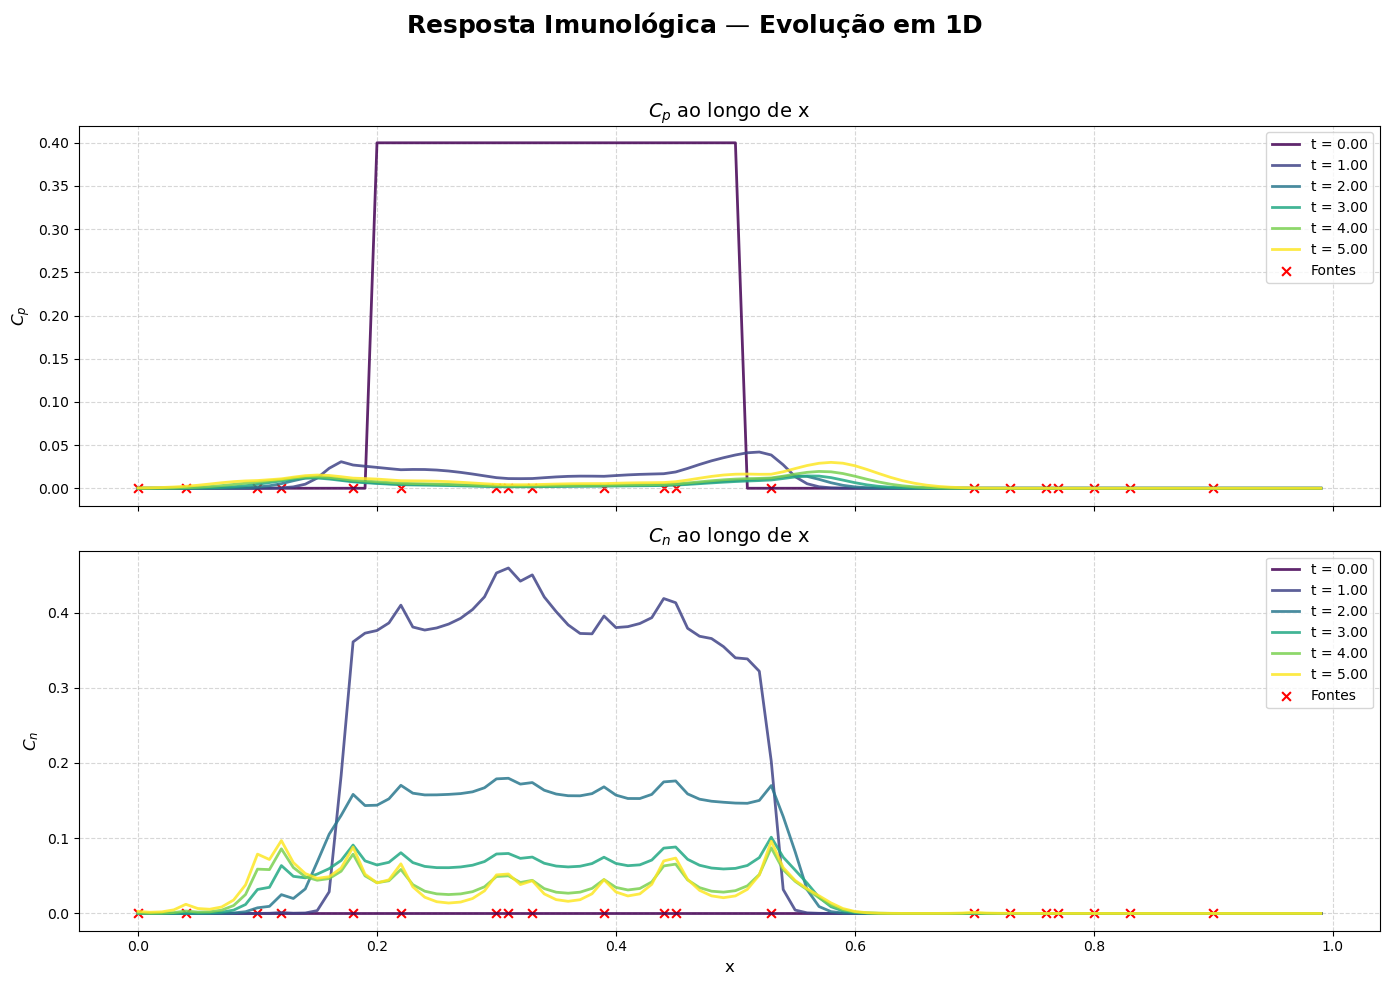

In [7]:
with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

plot_results(size_t,size_x,t_dom,x_dom,Cp_fvm,Cl_fvm,leu_source_points)

## Allocate GPU memmory

In [8]:
def under_sampling(n_samples, Cl, Cp):

    choosen_points = np.linspace(
        0, len(Cl) - 1, num=n_samples, endpoint=True, dtype=int
    )

    reduced_Cl = np.zeros((n_samples, Cl.shape[1], Cl.shape[2]))

    reduced_Cp = np.zeros((n_samples, Cp.shape[1], Cl.shape[2]))

    for i, idx in enumerate(choosen_points):

        reduced_Cl[i, :] = Cl[idx, :, :]

        reduced_Cp[i, :] = Cp[idx, :, :]

    return reduced_Cl, reduced_Cp, choosen_points

In [9]:
size = 4
source = leu_source_points

x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size, endpoint=False, dtype=np.float32
    )

x_idx = np.linspace(0, size, num=size, endpoint=False, dtype=int)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size, endpoint=True, dtype=np.float32)

x_idx_mesh, t_mesh = np.meshgrid(
    x_idx,
    t_np,
)

x_mesh = np.zeros_like(t_mesh)

x_mesh = x_np[x_idx_mesh.ravel()]

x_mesh = np.zeros_like(t_mesh)
source_mesh = np.zeros_like(t_mesh)

x_mesh = x_np[x_idx_mesh.ravel()]
source_mesh = source[x_idx_mesh.ravel()]


In [10]:
def create_input_mesh(source, t_dom, x_dom, size_t, size_x, n_samples=None):

    x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32
    )

    x_idx = np.linspace(0, size_x, num=size_x, endpoint=False, dtype=int)

    if n_samples:

        reduced_Cl, reduced_Cp, choosen_points = under_sampling(
            n_samples, Cl_fvm, Cp_fvm
        )

        t_np = np.linspace(
            t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32
        )[choosen_points]

        x_idx_mesh, t_mesh = np.meshgrid(
            x_idx,
            t_np,
        )

        x_mesh = np.zeros_like(t_mesh)
        source_mesh = np.zeros_like(t_mesh)

        x_mesh = x_np[x_idx_mesh.ravel()]
        source_mesh = source[x_idx_mesh.ravel()]

        return (
            reduced_Cl,
            reduced_Cp,
            t_mesh,
            x_mesh,
            source_mesh,
        )

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)

    x_idx_mesh, t_mesh = np.meshgrid(
        x_idx,
        t_np,
    )

    x_mesh = np.zeros_like(t_mesh)
    source_mesh = np.zeros_like(t_mesh)

    x_mesh = x_np[x_idx_mesh.ravel()]
    source_mesh = source[x_idx_mesh.ravel()]

    return (
        t_mesh,
        x_mesh,
        source_mesh,
    )

In [11]:
def allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center_x,
    initial_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    source,
    n_samples=None,
):

    (
        t_mesh,
        x_mesh,
        src_mesh,
    ) = create_input_mesh(source, t_dom, x_dom, size_t, size_x)

    if torch.cuda.is_available():
        device = torch.device("cuda")

    else:
        device = "cpu"

    print("device:", device)

    initial_tc = (
        torch.tensor(initial_cond, dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    center_x_tc = (
        torch.tensor(center_x, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    radius_tc = (
        torch.tensor(radius, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    t_tc = torch.tensor(t_mesh, dtype=torch.float32).reshape(-1, 1)

    x_tc = torch.tensor(x_mesh, dtype=torch.float32).reshape(-1, 1)

    data_tc = torch.cat([t_tc, x_tc], dim=1).requires_grad_(True).to(device)

    src_tc = (
        torch.tensor(src_mesh, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    target = torch.tensor(
        np.array([Cl_fvm.flatten(), Cp_fvm.flatten()]).T,
        dtype=torch.float32,
    )

    if n_samples:

        (
            reduced_Cl,
            reduced_Cp,
            reduced_t_mesh,
            reduced_x_mesh,
            reduced_src_mesh,
        ) = create_input_mesh(source, t_dom, x_dom, size_t, size_x, n_samples)

        reduced_t_tc = torch.tensor(reduced_t_mesh, dtype=torch.float32).reshape(-1, 1)

        reduced_x_tc = torch.tensor(reduced_x_mesh, dtype=torch.float32).reshape(-1, 1)

        reduced_data_tc = (
            torch.cat([reduced_t_tc, reduced_x_tc], dim=1)
            .requires_grad_(True)
            .to(device)
        )

        reduced_src_tc = (
            torch.tensor(reduced_src_mesh, dtype=torch.float32)
            .reshape(-1, 1)
            .requires_grad_(True)
        )

        reduced_target = torch.tensor(
            np.array([reduced_Cl.flatten(), reduced_Cp.flatten()]).T,
            dtype=torch.float32,
        )

        return (
            initial_tc,
            center_x_tc,
            radius_tc,
            data_tc,
            src_tc,
            target,
            reduced_data_tc,
            reduced_src_tc,
            reduced_target,
            device,
        )

    else:
        return (
            initial_tc,
            center_x_tc,
            radius_tc,
            data_tc,
            src_tc,
            target,
            device,
        )

In [12]:
n_samples = 1
(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target,
    reduced_data_tc,
    reduced_src_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    source,
    n_samples,
)

device: cuda


## Allocation validation

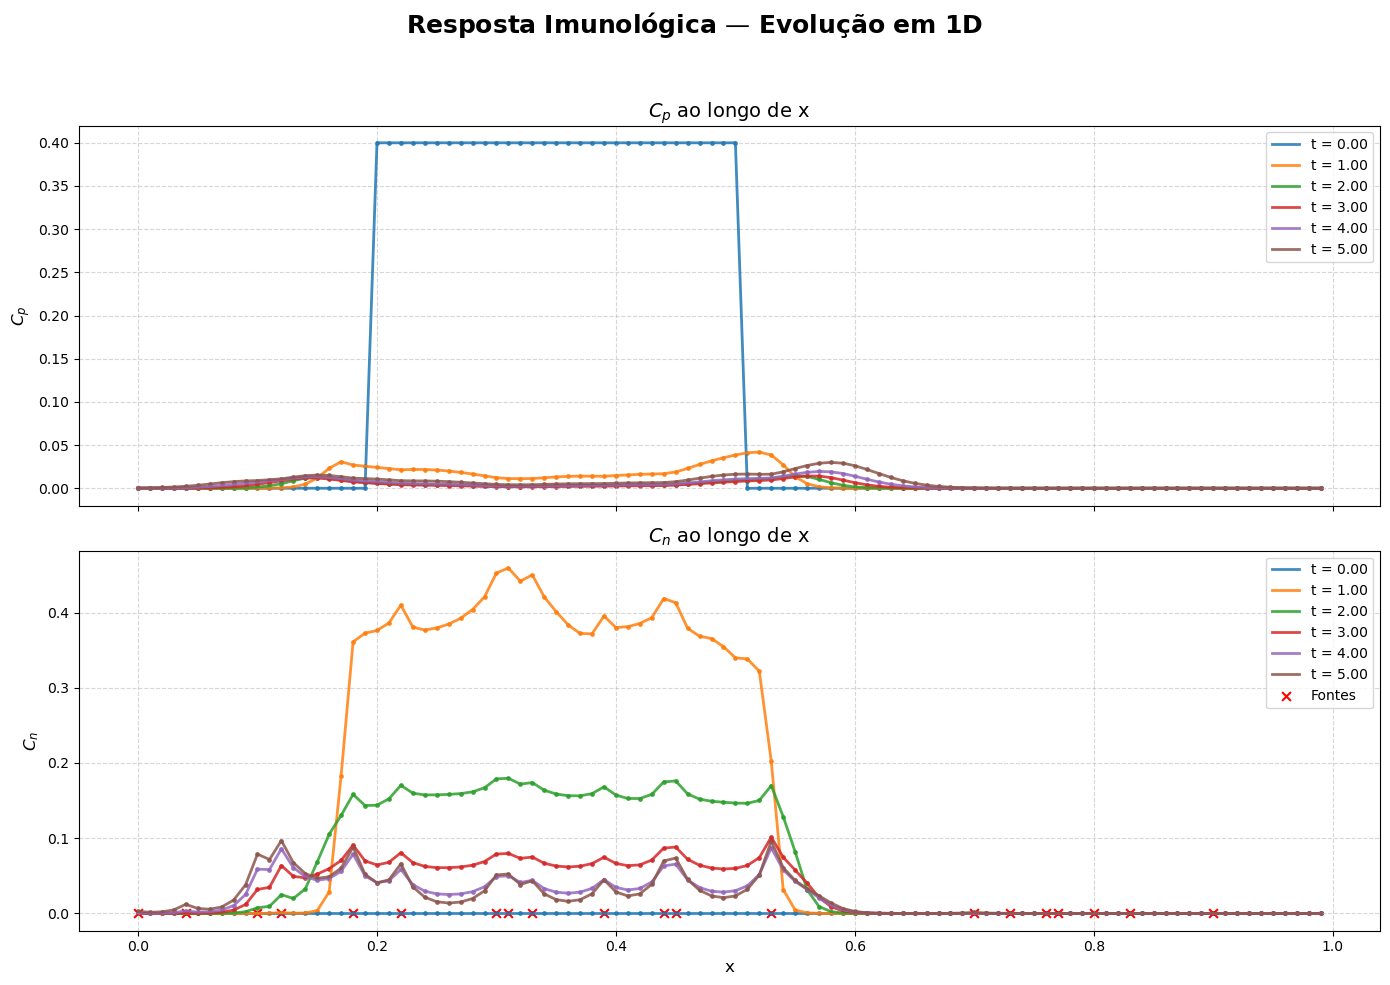

In [13]:
Cl_tc, Cp_tc = target.split(1, dim=1)

Cl = Cl_tc.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp = Cp_tc.cpu().detach().numpy().reshape(Cl_fvm.shape)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32)

# t_np, x_np, Cp, Cl, source_index already defined
# source_index is assumed to be an array of x positions only (1D or Nx1)

time_plot = np.linspace(0, size_t - 1, num=6, endpoint=True, dtype=int)

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fig.suptitle(
    "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
)

source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()


for i, time_inst in enumerate(time_plot):
    axes[0].plot(
        x_np,
        Cp[time_inst].squeeze(),
        label=f"t = {t_np[time_inst]:.2f}",
        linewidth=2,
        alpha=0.85,
    )

    time_ft = np.argwhere(
        data_tc[:, 0].cpu().detach().numpy() == t_np[time_inst]
    ).ravel()

    axes[0].scatter(
        data_tc[time_ft, 1].cpu().detach().numpy(),
        Cp_tc[time_ft].detach().numpy(),
        s=6,
        alpha=0.85,
    )

axes[0].set_title("$C_p$ ao longo de x", fontsize=14)
axes[0].set_ylabel("$C_p$", fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot Cl
for i, time_inst in enumerate(time_plot):
    axes[1].plot(
        x_np,
        Cl[time_inst].squeeze(),
        label=f"t = {t_np[time_inst]:.2f}",
        linewidth=2,
        alpha=0.85,
    )

    time_ft = np.argwhere(
        data_tc[:, 0].cpu().detach().numpy() == t_np[time_inst]
    ).ravel()

    axes[1].scatter(
        data_tc[time_ft, 1].cpu().detach().numpy(),
        Cl_tc[time_ft].detach().numpy(),
        s=6,
        alpha=0.85,
    )

axes[1].scatter(
    x_np[source_index],
    np.zeros((len(source_index))),
    color="red",
    label="Fontes",
    s=40,
    marker="x",
)

axes[1].set_title("$C_n$ ao longo de x", fontsize=14)
axes[1].set_xlabel("x", fontsize=12)
axes[1].set_ylabel("$C_n$", fontsize=12)
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Archtecture handling

In [14]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# PINN

## Training

In [15]:
def generate_pde_points(num_points, device):
    # Generate random (uniform) points in [0, 1) for time, x, and y
    t = torch.rand(num_points, 1, dtype=torch.float32) * 5

    x = torch.rand(num_points, 1, dtype=torch.float32)

    C = torch.zeros((len(x), 2), dtype=torch.float32)

    # Set requires_grad=True so we can compute PDE derivatives using autograd
    # Move each tensor to the specified device
    return (
        torch.cat([t.requires_grad_(True), x.requires_grad_(True)], dim=1).to(device),
        C.to(device),
    )


def generate_boundary_points(num_points, device):

    t = torch.rand(num_points, 1, dtype=torch.float32) * 5

    x = (
        torch.tensor([0.0, 1], dtype=torch.float32)
        .repeat(num_points // 2, 1)
        .view(-1, 1)
    )

    C = torch.zeros((len(x), 2), dtype=torch.float32)

    return (
        torch.cat([t.requires_grad_(True), x.requires_grad_(True)], dim=1).to(device),
        C.to(device),
    )


def generate_initial_points(num_points, device, center_x_tc, radius_tc, initial_tc):
    t = torch.zeros(num_points, 1, dtype=torch.float32)

    x = torch.rand(num_points, 1, dtype=torch.float32)

    euclidean_distances = ((x - center_x_tc) ** 2) ** 0.5

    inside_circle_mask = euclidean_distances <= radius_tc

    C_init = torch.zeros((len(x), 2), dtype=torch.float32)

    C_init[:, 1] = inside_circle_mask.ravel() * initial_tc.ravel()

    return (
        torch.cat([t.requires_grad_(True), x.requires_grad_(True)], dim=1).to(device),
        C_init.to(device),
    )


def boundary_condition(pred, batch, Dn, X_nb, Db):

    n = (
        torch.tensor([-1, 1], dtype=torch.float32)
        .repeat(len(pred) // 2, 1)
        .requires_grad_(True)
        .view(-1, 1)
        .to(device)
    )

    dCl = torch.autograd.grad(
        pred[:, 0],
        batch,
        torch.ones_like(pred[:, 0]),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp = torch.autograd.grad(
        pred[:, 1],
        batch,
        torch.ones_like(pred[:, 1]),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Separar as derivadas parciais em duas colunas
    _, dCl_dx = dCl.tensor_split(2, dim=1)
    _, dCp_dx = dCp.tensor_split(2, dim=1)

    Cl_boundary = Dn * dCl_dx * n - X_nb * torch.matmul(pred[:, 0].ravel(), dCp_dx * n)

    Cp_boundary = Db * dCp_dx * n

    # 4) Return them as one tensor, do NOT re-flag requires_grad
    return torch.cat([Cl_boundary, Cp_boundary], dim=1)


def generate_pde_source(original_source, h, batch):
   
    _, x_batch = batch.tensor_split(2, dim=1)  # [B, 1]
    x_domain = torch.arange(0, 1, h).view(-1, 1).to(device)  # [N, 1]

    # Identify active source locations in x_domain
    source_locs = x_domain[original_source.view(-1) == 1]  # shape [M, 1], where M ≤ N
    source_locs

    # Compute bounds
    l_bound = source_locs - h  # [M, 1]
    u_bound = source_locs + h  # [M, 1]

    # Broadcast and check
    x_batch_exp = x_batch[:, None, :]     # [B, 1, 1]
    l_bound_exp = l_bound[None, :, :]     # [1, M, 1]
    u_bound_exp = u_bound[None, :, :]     # [1, M, 1]

    # Check if x_batch[i] is within any [l_bound[j], u_bound[j]]
    in_range = (x_batch_exp > l_bound_exp) & (x_batch_exp < u_bound_exp)  # [B, M, 1]
    match = in_range.any(dim=1)  # [B, 1]

    # Generate new source
    new_source = torch.zeros_like(x_batch)
    new_source[match] = 1.0

    return new_source


def pde(
    pred,
    batch,
    h,
    cb,
    phi,
    lambd_nb,
    Db,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    Dn,
    X_nb,
    original_source,
):

    dCl = torch.autograd.grad(
        pred[:, 0],
        batch,
        torch.ones_like(pred[:, 0]),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp = torch.autograd.grad(
        pred[:, 1],
        batch,
        torch.ones_like(pred[:, 1]),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Separar as derivadas parciais em duas colunas
    dCl_dt, dCl_dx = dCl.tensor_split(2, dim=1)
    dCp_dt, dCp_dx = dCp.tensor_split(2, dim=1)

    d2Cl = torch.autograd.grad(
        dCl_dx,
        batch,
        torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    d2Cp = torch.autograd.grad(
        dCp_dx,
        batch,
        torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Separar as derivadas parciais em duas colunas
    _, d2Cl_dx2 = d2Cl.tensor_split(2, dim=1)
    _, d2Cp_dx2 = d2Cp.tensor_split(2, dim=1)

    # Calculating Cl value

    source = generate_pde_source(original_source,h,batch)

    qn = y_n * pred[:, 1:2] * (Cn_max - pred[:, 0:1]) * source # [1000, 1]
    rn = lambd_bn * pred[:, 0:1] * pred[:, 1:2] + mi_n * pred[:, 0:1]  # [1000, 1]

    Cl_eq = (
        Dn * d2Cl_dx2 - X_nb * (pred[:, 1:2] * d2Cp_dx2 + dCl_dx * dCp_dx) - rn + qn
    ) - dCl_dt * phi  # All shapes [1000, 1]

    qb = cb * pred[:, 1:2]
    rb = lambd_nb * pred[:, 0:1] * pred[:, 1:2]

    Cp_eq = Db * d2Cp_dx2 - rb + qb - dCp_dt * phi  # All shapes [1000, 1]

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [21]:
class Trainer:

    def shuffle_data(self, *arrays):
        indices = np.random.permutation(arrays[0].shape[0])

        return tuple(array[indices] for array in arrays)

    def train_test_split(
        self,
        *arrays,
        test_size=0.5,
        shuffle=True,
    ):
        with torch.no_grad():
            if shuffle:
                arrays = self.shuffle_data(*arrays)

            # Determine train-test split index
            total_samples = arrays[0].shape[0]
            if 0 < test_size < 1:
                split_idx = total_samples - int(total_samples * test_size)
            elif isinstance(test_size, int) and 1 <= test_size < total_samples:
                split_idx = total_samples - test_size
            else:
                raise ValueError(
                    "Invalid test_size: must be a float (0 < x < 1) or int < len(data)"
                )

            # Perform the split for each array
            train_set = tuple(array[:split_idx].to(self.device) for array in arrays)
            test_set = tuple(array[split_idx:].to(self.device) for array in arrays)

            # Flatten and return
            return (*train_set, *test_set)

    def add_loss(self, loss_obj, weigth=1):
        self.losses.append(loss_obj)
        self.lossesW.append(weigth)

    def __init__(
        self,
        n_epochs,
        batch_size,
        model,
        device,
        target=[],
        data=[],
        patience=300,
        tolerance=1e-3,
        val_steps=None,
        print_steps=5000,
        validation=None,
        optimizer=None,
        scheduler=None,
    ):

        self.model = model.to(device)
        self.device = device
        self.constant_properties = constant_properties
        self.validation = validation
        self.tolerance = tolerance
        self.patience = patience
        self.optimizer = optimizer
        self.scheduler = scheduler if scheduler else None
        self.print_steps = print_steps
        self.losses = []
        self.lossesW = []

        if len(data) != 0 and len(target) != 0:

            self.n_batchs = int(ceil(len(data) / batch_size))

            self.val_steps = val_steps if val_steps else self.n_batchs

            self.n_it = int(n_epochs * self.n_batchs)

            if self.validation:
                (
                    self.data_train,
                    self.target_train,
                    self.data_test,
                    self.target_test,
                ) = self.train_test_split(
                    data,
                    target,
                    test_size=self.validation,
                )

            else:

                self.data_train = data
                self.data_test = None
                self.target_train = target
                self.target_test = None

            self.add_loss(
                RMSE(
                    self.data_train,
                    self.target_train,
                    device,
                    name="Data Loss",
                    batch_size=batch_size,
                    shuffle=False,
                )
            )

            return

        self.n_it = n_epochs
        self.val_steps = val_steps if val_steps else 1

        return

    def train(
        self,
    ):

        if self.losses == []:
            print("No loss function added")
            return

        loss_dict = {}

        for loss in self.losses:
            loss_dict[loss.name] = []

        loss_dict["val"] = []

        patience_count = 0
        val_min = torch.tensor([1000])
        val_loss = torch.tensor([1000])

        for it in range(self.n_it):
            start_time = time.time()  # Start timing the iteration

            self.model.zero_grad()
            self.optimizer.zero_grad()
            total_loss = 0
            losses = []

            for weighth, loss_obj in zip(self.lossesW, self.losses):

                loss = loss_obj.forward(self.model)

                total_loss += loss * weighth

                losses.append((loss * weighth).item())

                if it % self.n_batchs == 0:
                    loss_dict[loss_obj.name].append(loss.item())

            # Backward pass
            total_loss.backward()

            # Update weights
            self.optimizer.step()

            iteration_time = time.time() - start_time  # Calculate iteration duration

            if it / self.n_batchs % self.print_steps == 0:
                print(
                    "Iteration {}: total loss {:.4f}, losses: {}, learning rate: {:.10f}, time: {:.4f}s".format(
                        it // self.n_batchs,
                        total_loss.item(),
                        losses,
                        self.scheduler.get_last_lr()[0],
                        iteration_time,
                    )
                )

            self.scheduler.step(total_loss)

            # Computing validation loss

            if it % self.val_steps // self.n_batchs:
                with torch.no_grad():

                    val_loss = torch.mean(
                        torch.sum(
                            ((self.target_test - self.model(self.data_test))) ** 2,
                            dim=1,
                        )
                        ** 0.5
                    )

                if it % self.n_batchs == 0:
                    loss_dict["val"].append(val_loss.item())

                if self.tolerance and self.validation:

                    if val_loss.item() < val_min.item() * (1 - self.tolerance):
                        
                        val_min = val_loss
                        
                        patience_count = 0

                        best_state = self.model.state_dict()

                        it_break = it

                    else:
                        patience_count += 1

                    if patience_count >= self.patience:

                        print(
                            "Iteration {}: total loss {:.4f}, losses: {}, learning rate: {:.10f}, time: {:.4f}s".format(
                                it // self.n_batchs,
                                total_loss.item(),
                                losses,
                                self.scheduler.get_last_lr()[0],
                                iteration_time,
                            )
                        )

                        self.model.load_state_dict(best_state)

                        print("Early break on iteration: ", it_break)

                        break

        return self.model, loss_dict

In [22]:
hidden_layer = [32, 32, 32, 32, 32]
dtype = torch.float32
model = FullyConnectedNetwork(2, 2, hidden_layer, dtype=dtype)
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

FullyConnectedNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Tanh()
    (10): Linear(in_features=32, out_features=2, bias=True)
  )
)
4386


In [23]:
n_epochs = int(1e4)
batch_size = int(1e4)
beta1 = 0.7
beta2 = 0.999

optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.7, 0.999))
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.9999,
    patience=1000,
    threshold=1e-3,
    threshold_mode="rel",
    cooldown=0,
    min_lr=1e-5,
    eps=1e-08,
)

trainer = Trainer(
    n_epochs=n_epochs,
    batch_size=batch_size,
    model=model,
    device=device,
    target=target,
    data=data_tc,
    patience=3000,
    tolerance=0.01,
    validation=0.2,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    print_steps=2000,
)

In [ ]:
init_loss = LOSS_INITIAL(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossInital",
)

init_loss.setBatchGenerator(generate_initial_points, center_x_tc, radius_tc, initial_tc)

trainer.add_loss(init_loss)


bnd_loss = LOSS_PINN(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossBoundary",
)

bnd_loss.setBatchGenerator(generate_boundary_points)

bnd_loss.setPinnFunction(boundary_condition, Dn, X_nb, Db)

trainer.add_loss(bnd_loss)


pde_loss = LOSS_PINN(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossPDE",
)

pde_loss.setBatchGenerator(generate_pde_points)


original_source = torch.tensor(leu_source_points).to(device)

pde_loss.setPinnFunction(
    pde,
    h,
    cb,
    phi,
    lambd_nb,
    Db,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    Dn,
    X_nb,
    original_source,
)

trainer.add_loss(pde_loss, 5)

In [ ]:
model, loss_dict = trainer.train()


Iteration 0: total loss 1.7874, losses: [0.1768060028553009, 0.24530626833438873, 0.015602425672113895, 1.3496876955032349], learning rate: 0.0010000000, time: 0.1143s
Iteration 2000: total loss 0.1942, losses: [0.07173636555671692, 0.11921259760856628, 1.7482682324043708e-06, 0.003207987640053034], learning rate: 0.0009981017, time: 0.0238s
Iteration 4000: total loss 0.0914, losses: [0.02913554571568966, 0.014603393152356148, 0.00011944205471081659, 0.04755791649222374], learning rate: 0.0009970043, time: 0.0250s


## Validation

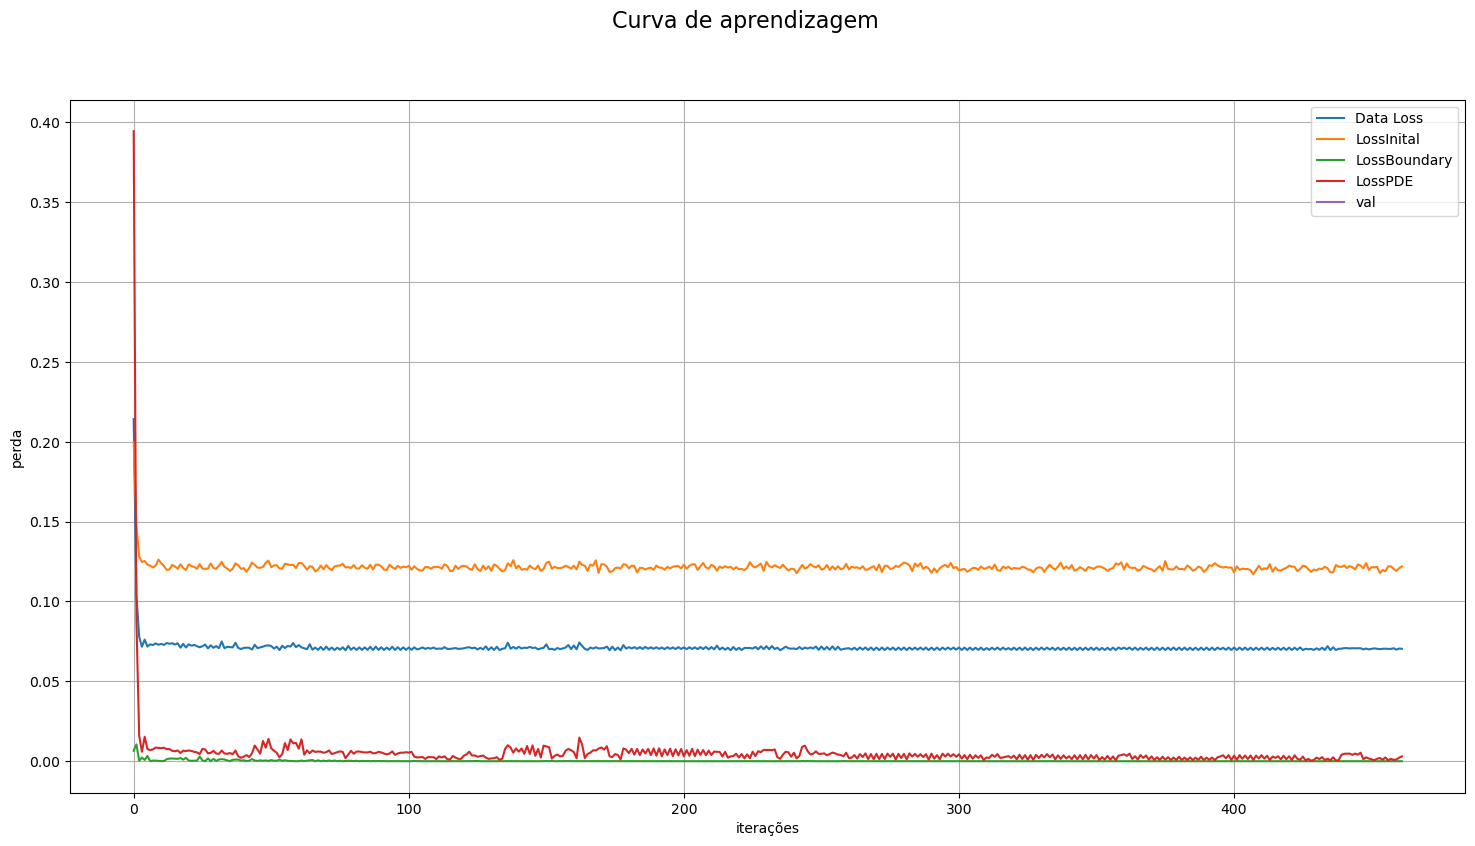

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

for loss in loss_dict:
    ax.plot(
        range(len(loss_dict[loss])),
        loss_dict[loss],
        label=loss,
    )

# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [22]:
model = trainer.model

mesh = data_tc.to(device)

with torch.no_grad():
    pred_pinn_dev = model(mesh)

pred_pinn = pred_pinn_dev.cpu().detach().numpy()

In [23]:
Cl_pinn_device, Cp_pinn_device = pred_pinn_dev.split(1, dim=1)

Cl_pinn_np = Cl_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp_pinn_np = Cp_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)

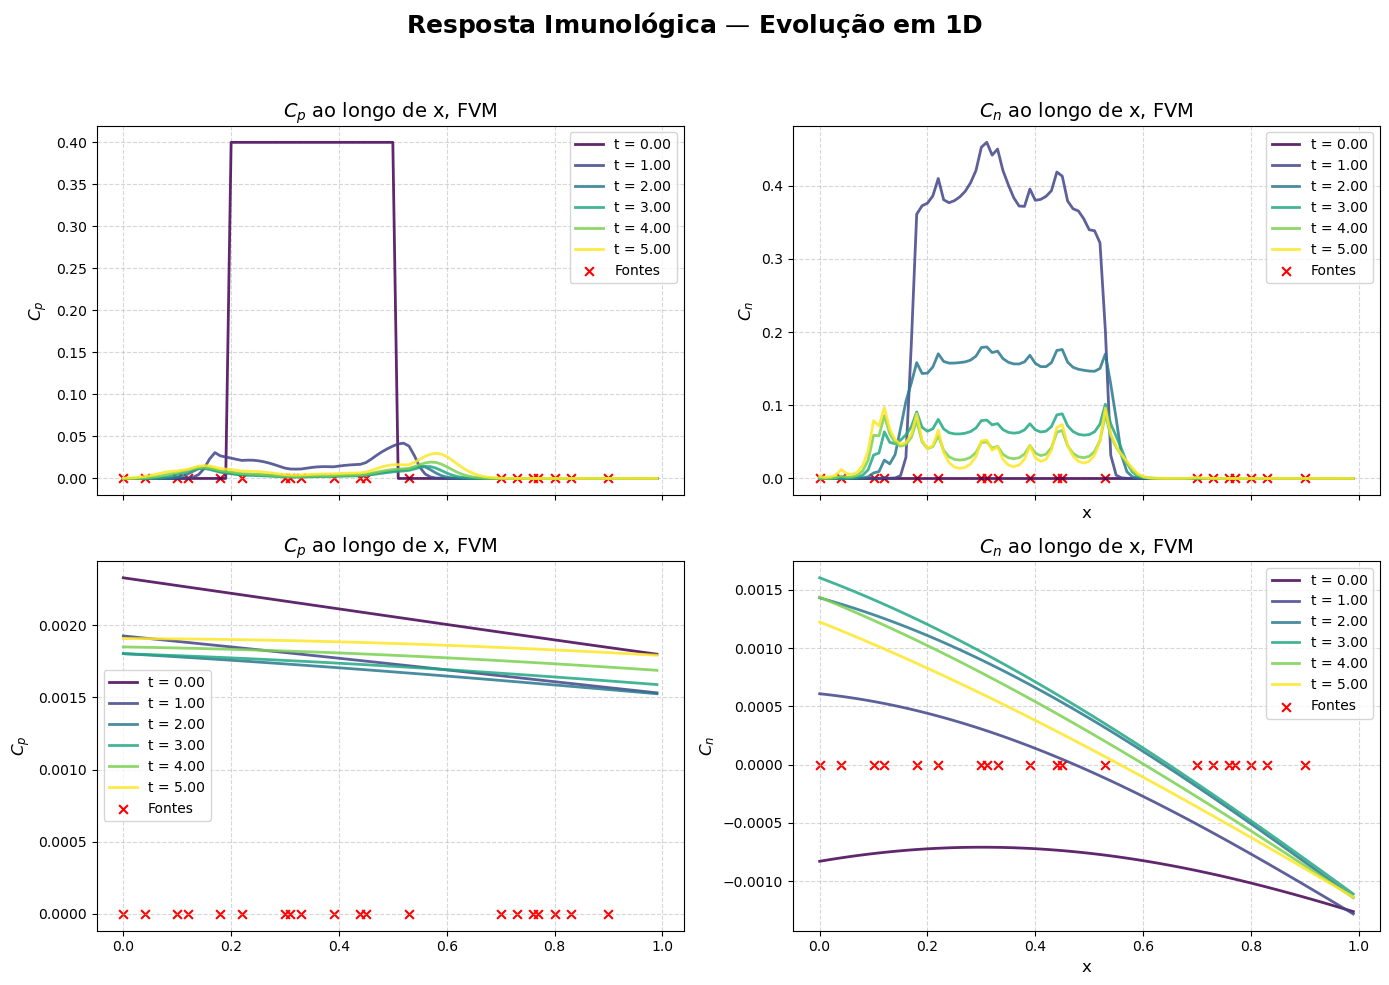

In [25]:
from utils import plot_comparison, animate_1D_comparison

plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_fvm,
    Cl_fvm,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
)


In [13]:

animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_fvm,
    Cl_fvm,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__",
)


NameError: name 'Cp_pinn_np' is not defined

## Saving model weights and biases

In [30]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
layers.0.weight 	 torch.Size([32, 2])
layers.0.bias 	 torch.Size([32])
layers.2.weight 	 torch.Size([32, 32])
layers.2.bias 	 torch.Size([32])
layers.4.weight 	 torch.Size([32, 32])
layers.4.bias 	 torch.Size([32])
layers.6.weight 	 torch.Size([32, 32])
layers.6.bias 	 torch.Size([32])
layers.8.weight 	 torch.Size([32, 32])
layers.8.bias 	 torch.Size([32])
layers.10.weight 	 torch.Size([2, 32])
layers.10.bias 	 torch.Size([2])


In [31]:
import os


arch_str = ""

for hd in hidden_layer: arch_str += ("__" + str(hd))


pinn_file = "beta1_{}__beta2_{}".format(beta1, beta2) + arch_str

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

del model
del trainer

# Training setup

In [ ]:
import torch
import pickle as pk
import os
import json
from pinn import *
import argparse

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    leu_source_points,
)


arch_str = "32__32__32__32__32"

n_epochs = int(1e4)

batch_size = int(1e4)

beta1 = 0.7

beta2 = 0.999

hidden_layer = [int(n_neurons) for n_neurons in arch_str.split("__")]

dtype = torch.float32

model = FullyConnectedNetwork(2, 2, hidden_layer, dtype=dtype)

arch_str = ""

for hd in hidden_layer:
    arch_str += "__" + str(hd)

pinn_file = "beta1_{}__beta2_{}".format(beta1, beta2) + arch_str


print("\n" + pinn_file)

print("=" * 20)

print(
    "Number of parameters",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
)

optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(beta1, beta2))
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.9999,
    patience=1000,
    threshold=1e-3,
    threshold_mode="rel",
    cooldown=0,
    min_lr=1e-5,
    eps=1e-08,
)

trainer = Trainer(
    n_epochs=n_epochs,
    batch_size=batch_size,
    model=model,
    device=device,
    target=target,
    data=data_tc,
    patience=5000,
    tolerance=0.01,
    validation=0.2,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    print_steps=2000,
    constant_properties=constant_properties,
)


init_loss = LOSS_INITIAL(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossInital",
)

init_loss.setBatchGenerator(generate_initial_points, center_x_tc, radius_tc, initial_tc)

trainer.add_loss(init_loss)


bnd_loss = LOSS_PINN(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossBoundary",
)

bnd_loss.setBatchGenerator(generate_boundary_points)

bnd_loss.setPinnFunction(boundary_condition, Dn, X_nb, Db, device)

trainer.add_loss(bnd_loss)


pde_loss = LOSS_PINN(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossPDE",
)

pde_loss.setBatchGenerator(generate_pde_points)

original_source = torch.tensor(leu_source_points).to(device)

pde_loss.setPinnFunction(
    pde,
    h,
    cb,
    phi,
    lambd_nb,
    Db,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    Dn,
    X_nb,
    original_source,
    device,
)

trainer.add_loss(pde_loss, 5)

model, loss_dict = trainer.train()

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

with open("learning_curves/" + pinn_file + , "wb") as openfile:
    # Reading from json file
    pk.dump(loss_dict, openfile)


del model
del trainer

Steps in time = 1001
Steps in space_x = 100
Steps in space_y = 1

device: cuda

beta1_0.7__beta2_0.999__32__32__32__32__32
Number of parameters 4386
Iteration 0: total loss 1.3778, losses: [0.2571147382259369, 0.3322824537754059, 0.021703535690903664, 0.7667245864868164], learning rate: 0.0010000000, time: 0.1177s
Iteration 2000: total loss 0.1886, losses: [0.06664721667766571, 0.12052538990974426, 5.022485893846351e-08, 0.0013889133697375655], learning rate: 0.0009982015, time: 0.0065s
Iteration 4000: total loss 0.0882, losses: [0.04082677885890007, 0.009814695455133915, 8.322219946421683e-05, 0.037459179759025574], learning rate: 0.0009968050, time: 0.0076s
Iteration 6000: total loss 0.0705, losses: [0.030355369672179222, 0.007517942693084478, 0.0001478175399824977, 0.0325288288295269], learning rate: 0.0009954103, time: 0.0066s
Iteration 8000: total loss 0.0661, losses: [0.02485831454396248, 0.004766297992318869, 7.045090114843333e-06, 0.036436401307582855], learning rate: 0.0009938

# Evaluation setup

In [1]:
from glob import glob
import time
import pickle as pk
import os
import json
from pinn import *

In [14]:
def load_model(file_name, device):
    cwd = os.getcwd()

    hidden_layer = [int(n_neurons) for n_neurons in file_name.split("beta2_")[-1].split(".pt")[0].split("__")[1:]]
    
    dtype = torch.float32
    model = FullyConnectedNetwork(2, 2, hidden_layer, dtype=dtype)

    model.load_state_dict(
        torch.load(cwd + "/" + file_name, weights_only=True, map_location=device)
    )

    print(model.eval())

    return model.to(device)


def read_speed_ups(speed_up_list):
    speed_up_obj = {}
    for i, file in enumerate(speed_up_list):
        with open(file, "rb") as f:
            speed_up_obj[i] = pk.load(f)

    return speed_up_obj

In [15]:
import torch
import pickle as pk
import os
import json
from pinn import *
import argparse

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    leu_source_points,
)

Steps in time = 1001
Steps in space_x = 100
Steps in space_y = 1

device: cuda


In [17]:
nn_list = glob("nn_parameters/*")
run_list = list(
    map(
        lambda file: file.split("pinn_sim/")[-1]
        .split(".pkl")[0]
        .split("prediction_")[-1],
        glob("pinn_sim/*"),
    )
)

total = len(nn_list)

target = target.cpu().detach()

for nn_num, nn_file in enumerate(nn_list):

    if nn_file.split(".")[-1] == "pt":

        pinn_file = nn_file.split("nn_parameters/")[-1].split(".pt")[0]

        print(f"\n{nn_num+1} of {total}")

        print("=" * 20)

        print("PINN:", pinn_file)

        if pinn_file in run_list:
            print("Already evaluated")

        else:
            model = load_model(nn_file, device)

            speed_up_obj = read_speed_ups(speed_up_list)

            output = {
                "mean_speed_up": [],
                "std_speed_up": 0,
                "mean_speed_comp_up": [],
                "std_speed_comp_up": 0,
                "mean_speed_up_pinn": [],
                "std_speed_up_pinn": 0,
                "mean_serial_time": [],
                "std_serial_time": 0,
                "mean_cuda_time": [],
                "std_cuda_time": 0,
                "mean_pinn_time": [],
                "std_pinn_time": 0,
            }

            prediction = {}

            error = np.zeros((len(speed_up_obj.keys()), len(target)))

            for i in speed_up_obj.keys():

                start = time.time()

                mesh = data_tc.to(device)

                with torch.no_grad():
                    pred_pinn_dev = model(mesh)

                pred_pinn = pred_pinn_dev.cpu().detach().numpy()

                pred_pinn = pred_pinn_dev.cpu().detach().numpy()

                end = time.time()

                pinn_time = end - start

                speed_up_obj[i]["pinn_time"] = pinn_time

                speed_up_obj[i]["speed_up_pinn"] = (
                    speed_up_obj[i]["serial_time"] / pinn_time
                )

                output["mean_speed_up"].append(speed_up_obj[i]["speed_up"])

                output["mean_speed_comp_up"].append(speed_up_obj[i]["speed_comp_up"])

                output["mean_speed_up_pinn"].append(speed_up_obj[i]["speed_up_pinn"])

                output["mean_serial_time"].append(speed_up_obj[i]["serial_time"])

                output["mean_cuda_time"].append(speed_up_obj[i]["cuda_time"])

                output["mean_pinn_time"].append(speed_up_obj[i]["pinn_time"])

                aux = ((pred_pinn - target.cpu().detach().numpy()) ** 2) ** 0.5

                error[i] = aux[:, 0] + aux[:, 1]

            rmse = np.mean(error.flatten())

            max_ae = np.max(error.flatten())
            
            output["std_speed_up"] = np.std(output["mean_speed_up"])
            output["std_speed_comp_up"] = np.std(output["mean_speed_comp_up"])
            output["std_speed_up_pinn"] = np.std(output["mean_speed_up_pinn"])
            output["std_serial_time"] = np.std(output["mean_serial_time"])
            output["std_cuda_time"] = np.std(output["mean_cuda_time"])
            output["std_pinn_time"] = np.std(output["mean_pinn_time"])
            output["mean_speed_up"] = np.mean(output["mean_speed_up"])
            output["mean_speed_comp_up"] = np.mean(output["mean_speed_comp_up"])
            output["mean_speed_up_pinn"] = np.mean(output["mean_speed_up_pinn"])
            output["mean_serial_time"] = np.mean(output["mean_serial_time"])
            output["mean_cuda_time"] = np.mean(output["mean_cuda_time"])
            output["mean_pinn_time"] = np.mean(output["mean_pinn_time"])
            output["rmse"] = rmse
            output["max_ae"] = max_ae

            prediction["pred_pinn"] = pred_pinn
            prediction["target"] = target.cpu().detach().numpy()

            print("Erro absoluto médio", rmse)
            print("Erro absoluto máximo", max_ae)
            print(
                "Speed Up: {} +/-{}".format(
                    output["mean_speed_up"], output["std_speed_up"]
                )
            )
            print(
                "Compilation Speed Up: {} +/-{}".format(
                    output["mean_speed_comp_up"], output["std_speed_comp_up"]
                )
            )
            print(
                "PINN Speed Up: {} +/-{}".format(
                    output["mean_speed_up_pinn"], output["std_speed_up_pinn"]
                )
            )

            with open("pinn_sim/output_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(output, openfile)

            with open("pinn_sim/prediction_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(prediction, openfile)


1 of 190
PINN: beta1_0.75__beta2_0.99__32__32__32__32__32
FullyConnectedNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Tanh()
    (10): Linear(in_features=32, out_features=2, bias=True)
  )
)
Erro absoluto médio 0.04898883324861644
Erro absoluto máximo 1.1136504411697388
Speed Up: 216.52729908230725 +/-17.017893174641788
Compilation Speed Up: 0.6523709714829291 +/-0.17585119929814755
PINN Speed Up: 1737.0436803497885 +/-274.5919447525629

2 of 190
PINN: beta1_0.6__beta2_0.99495__8__8__8__8__8
FullyConnectedNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_fea

# Printing simulations

In [17]:
from utils import animate_1D_comparison, plot_comparison

with open("pinn_sim/prediction_" + pinn_file + ".pkl", "rb") as openfile:
    # Reading from json file
    prediction = pk.load(openfile)
    
with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

In [18]:
pred_pinn = prediction["pred_pinn"]
target = prediction["target"]

In [19]:
Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_target_dev, Cp_target_dev = np.split(target, 2, axis=1)

Cl_target_np = Cl_target_dev.reshape(Cp_fvm.shape)

Cp_target_np = Cp_target_dev.reshape(Cp_fvm.shape)

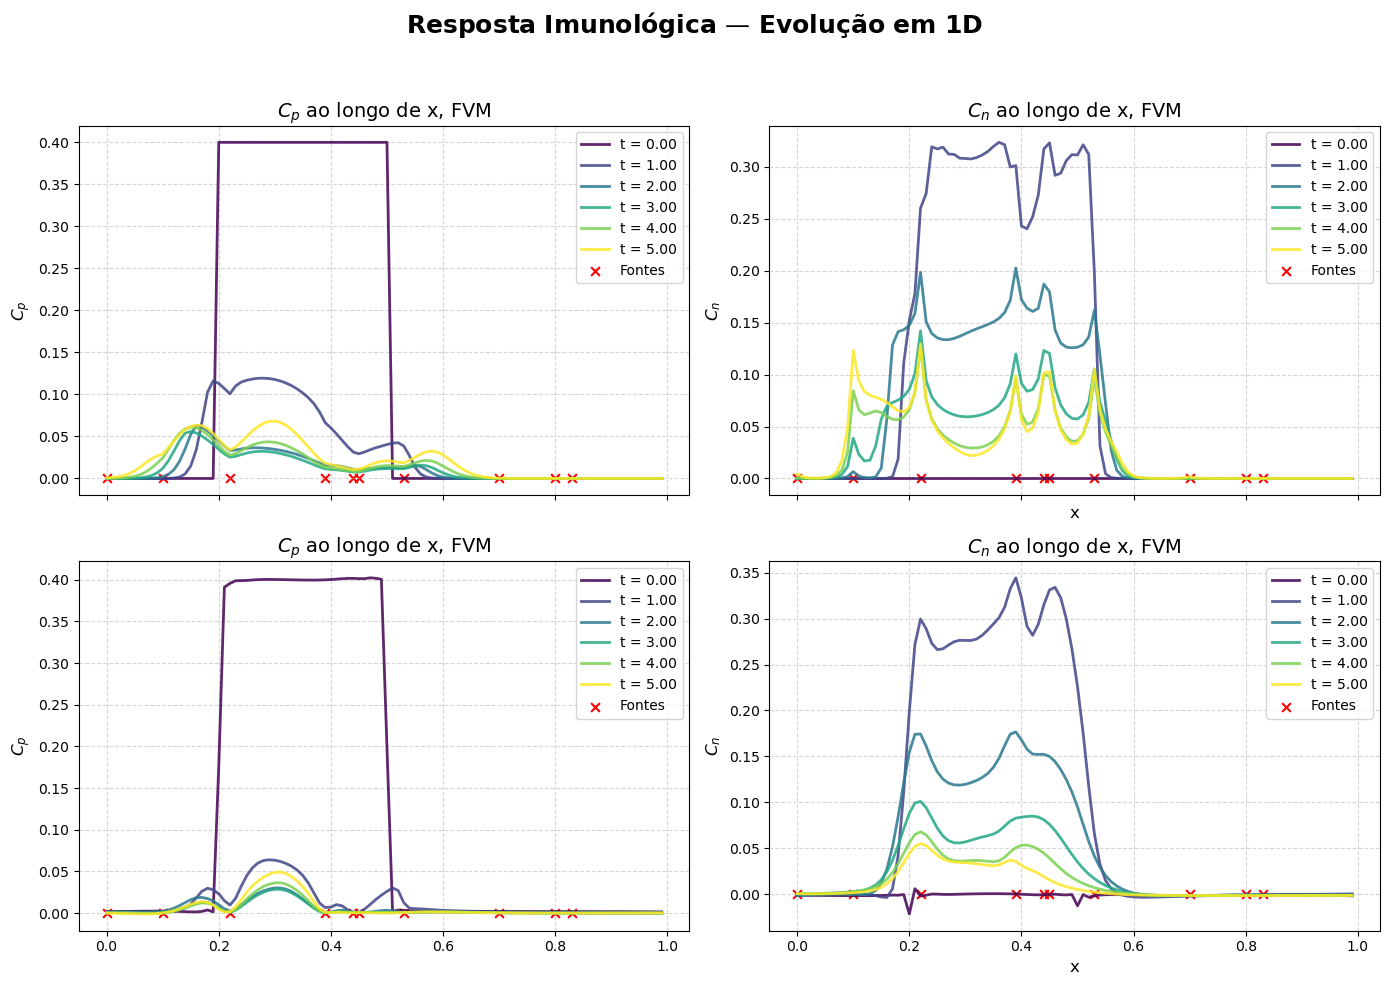

In [21]:
plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
)


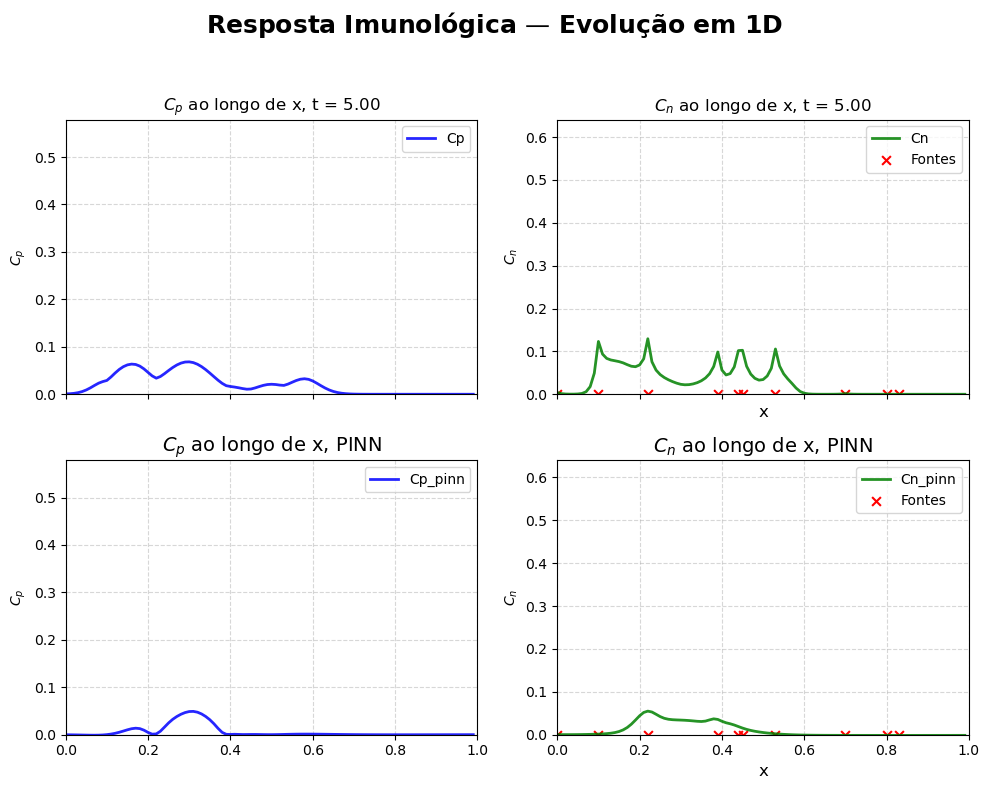

In [22]:
animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__pinn",
)
